# EDA — Craigslist Cars & Trucks Dataset

Analisi esplorativa del dataset **Craigslist Cars/Trucks** ([Kaggle](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data)), che costituisce la **Sorgente 1** nel nostro task di Entity Resolution.

L'obiettivo è valutare la qualità dei dati — completezza degli attributi, distribuzioni e pattern di valori mancanti — per definire le strategie di pulizia e di schema matching.

> **Nota:** questo notebook è puramente esplorativo. Il preprocessing effettivo è gestito dallo script `src.preparation.process_raw`.

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from src.config import RAW_DIR

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Caricamento dati

In [2]:
RAW_PATH = RAW_DIR / "vehicles.csv"
df = pd.read_csv(RAW_PATH)
print(f"Dataset caricato da: {RAW_PATH}")

Dataset caricato da: /teamspace/studios/this_studio/Record-Linkage/storage/raw/vehicles.csv


In [3]:
print(f"Dimensioni del dataset: {df.shape[0]} righe × {df.shape[1]} colonne")

Dimensioni del dataset: 426880 righe × 26 colonne


## 2. Panoramica del dataset

Dimensioni, tipi di dato e statistiche descrittive per un primo inquadramento della sorgente.

In [4]:
# Schema e tipi di dato
display(df.info())

# Statistiche descrittive sugli attributi numerici
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

None

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [5]:
def profiling_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Calcola, per ogni attributo, la % di valori mancanti, la % di valori
    unici e il tipo di dato. Restituisce un DataFrame trasposto."""
    missing_pct = (df.isnull().sum() / len(df)) * 100
    unique_pct  = (df.nunique() / len(df)) * 100
    dtypes      = df.dtypes.astype(str)

    return pd.DataFrame(
        [missing_pct, unique_pct, dtypes],
        index=['missing_values_%', 'unique_values_%', 'dtype'],
    )

## 3. Data profiling

Per ciascun attributo calcoliamo la percentuale di valori mancanti, la percentuale di valori unici e il tipo di dato, così da individuare le colonne a bassa informatività.

In [6]:
df_stats = profiling_dataset(df)
display(df_stats)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
missing_values_%,0.0,0.0,0.0,0.0,0.0,0.282281,4.133714,1.236179,40.785232,41.62247,0.705819,1.030735,1.930753,0.598763,37.725356,30.586347,71.767476,21.752717,30.501078,0.01593,0.016398,100.0,0.0,1.534155,1.534155,0.01593
unique_values_%,100.0,100.0,0.09464,0.096749,3.667307,0.026705,0.009839,6.949728,0.001406,0.001874,0.001171,24.566623,0.001406,0.000703,27.704273,0.000703,0.000937,0.003045,0.002811,56.666745,84.546243,0.0,0.011947,12.458068,12.596514,89.377811
dtype,int64,object,object,object,int64,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,float64,object,float64,float64,object


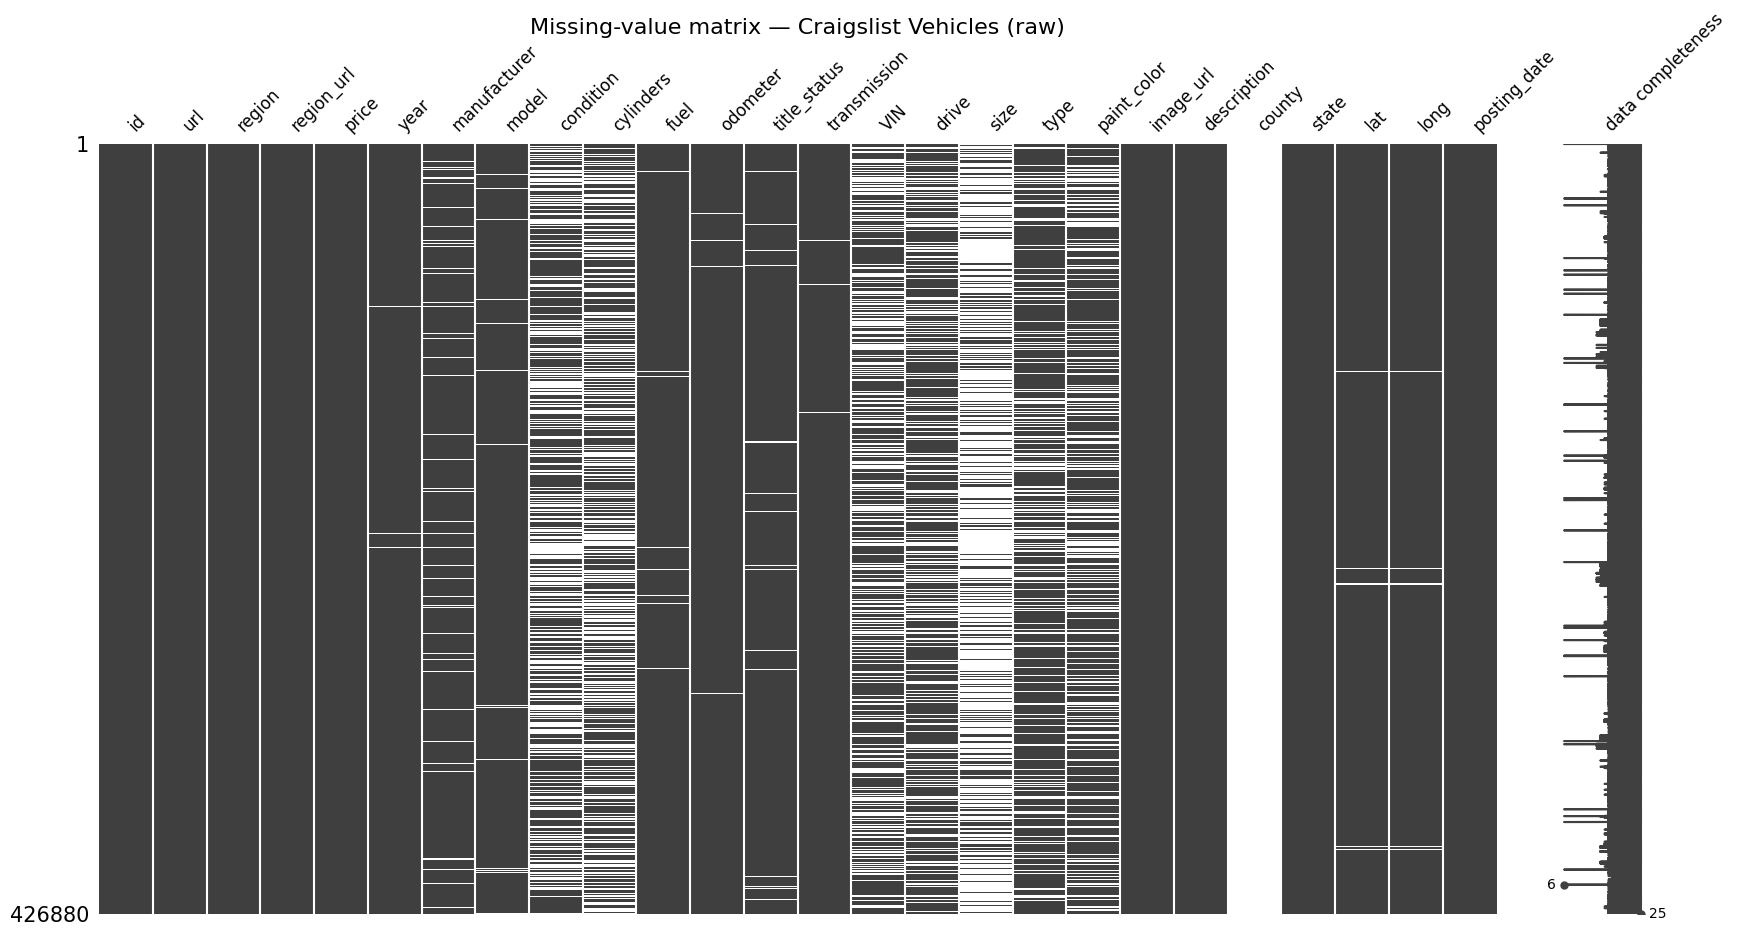

In [8]:
msno.matrix(df, figsize=(20, 10), fontsize=12, labels=True)
plt.title("Missing-value matrix — Craigslist Vehicles (raw)", fontsize=16)
plt.show()

## 4. Osservazioni

La matrice `missingno` evidenzia i pattern di completezza: le bande bianche corrispondono a valori assenti. Le colonne con oltre il 70% di missing e le righe prive degli attributi critici (`manufacturer`, `model`, `year`, `odometer`, `fuel`) vengono gestite nello step di preprocessing automatizzato (`python -m src.preparation.process_raw`).